In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


In [2]:
# === Create directory structure for model v2 ===
import os

os.makedirs("/kaggle/working/models", exist_ok=True)
os.makedirs("/kaggle/working/results", exist_ok=True)

print("Created folders:")
print(" - /kaggle/working/models")
print(" - /kaggle/working/results")


Created folders:
 - /kaggle/working/models
 - /kaggle/working/results


In [3]:
import os
import zipfile
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.optimizers import Adam



2025-11-21 15:08:15.669938: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763737695.862224      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763737695.917125      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
TEST_SIZE = 0.2
RANDOM_STATE = 42
BATCH_SIZE = 32
NO_EPOCHS = 10
NUM_CLASSES = 2
SAMPLE_SIZE = 20000
IMG_SIZE = 128

TRAIN_FOLDER = "/kaggle/working/train"
TEST_FOLDER  = "/kaggle/working/test"
PATH_TRAIN = '/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip'
PATH_TEST  = '/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip'


In [6]:


with zipfile.ZipFile(PATH_TRAIN, 'r') as zip_ref:
    zip_ref.extractall(TRAIN_FOLDER)
with zipfile.ZipFile(PATH_TEST, 'r') as zip_ref:
    zip_ref.extractall(TEST_FOLDER)

train_inner_folder = os.path.join(TRAIN_FOLDER, 'train')
test_inner_folder = os.path.join(TEST_FOLDER, 'test')

train_image_list = os.listdir(train_inner_folder)[:SAMPLE_SIZE]
test_image_list = os.listdir(test_inner_folder)

print("Found train images:", len(train_image_list))
print("Using SAMPLE_SIZE:", len(train_image_list))
print("Found test images:", len(test_image_list))


Found train images: 20000
Using SAMPLE_SIZE: 20000
Found test images: 12500


In [7]:
def label_pet_image_one_hot_encoder(img_filename):
    pet = img_filename.split('.')[0]
    if pet == 'cat': return [1,0]
    elif pet == 'dog': return [0,1]
    return [1,0]

In [8]:
def process_data(data_image_list, DATA_FOLDER, isTrain=True):
    data_df = []
    for img in data_image_list:
        path = os.path.join(DATA_FOLDER, img)
        if isTrain:
            label = label_pet_image_one_hot_encoder(img)
        else:
            label = img
        img_array = cv2.imread(path)
        if img_array is None:
            continue
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        data_df.append([np.array(img_array), np.array(label)])
    shuffle(data_df)
    return data_df

In [9]:
def plot_image_list_count(data_image_list):
    labels = []
    for img in data_image_list:
        labels.append(img.split('.')[0])   
    plt.figure(figsize=(6,4))
    sns.countplot(x=labels)
    plt.title('Cats and Dogs')
    plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


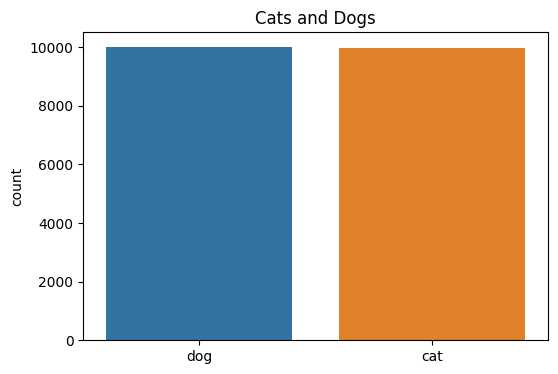

In [10]:
plot_image_list_count(train_image_list)

In [11]:
train = process_data(train_image_list, train_inner_folder, True)

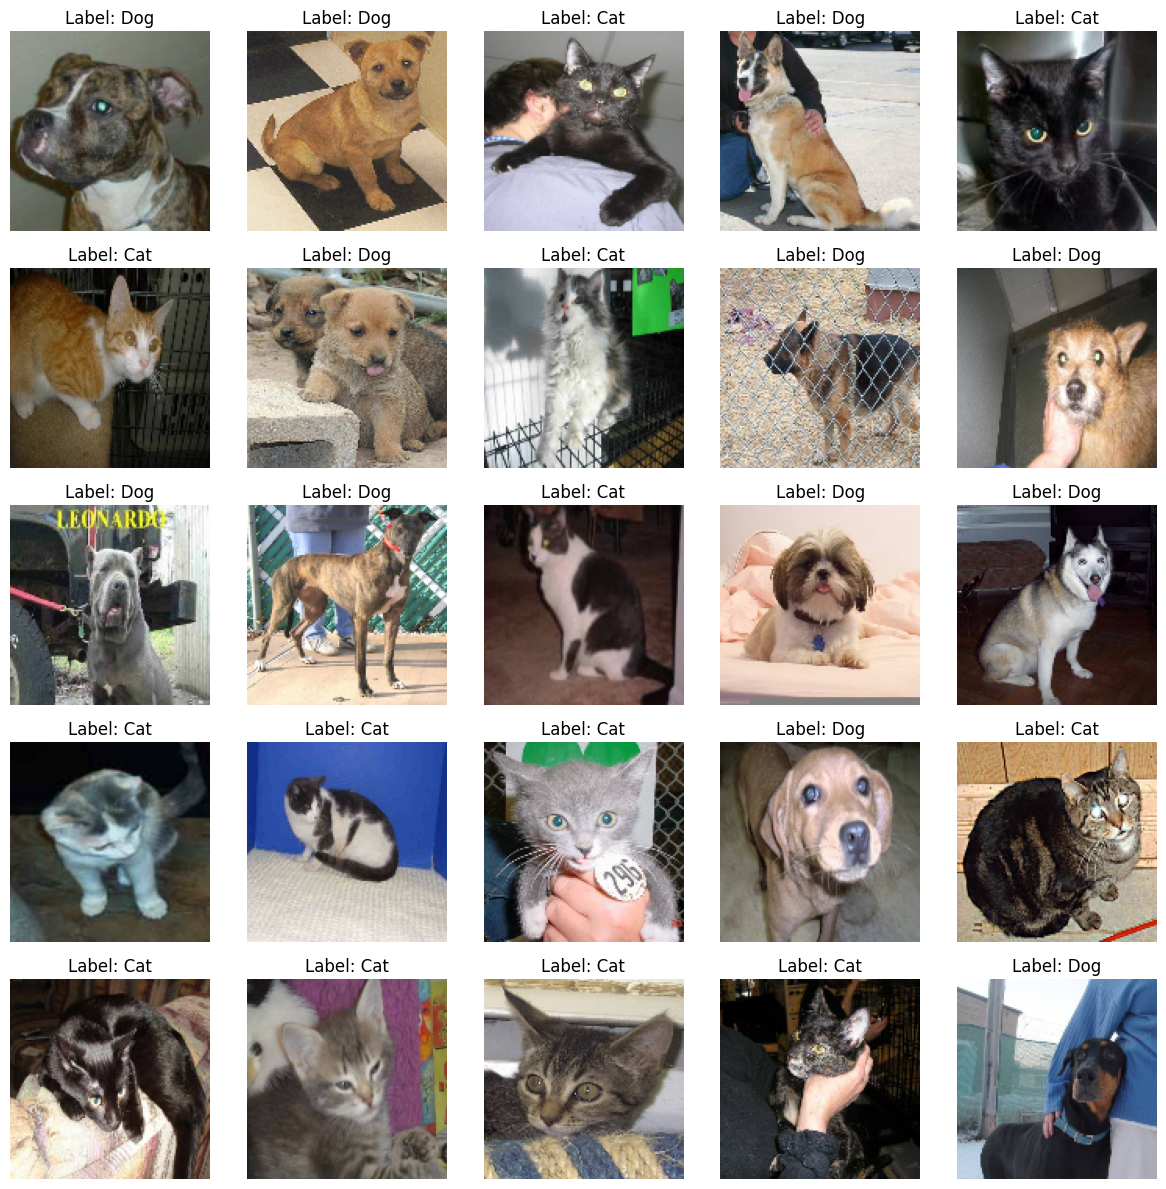

In [12]:
def show_images(data, isTest=False):
    f, ax = plt.subplots(5,5, figsize=(12,12))
    for i,item in enumerate(data[:25]):
        img_data = item[0]
        img_num = item[1]
        if isTest:
            str_label = "None"
        else:
            label = np.argmax(img_num)
            str_label = "Dog" if label == 1 else "Cat"
        ax[i//5, i%5].imshow(img_data.astype(np.uint8))
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title("Label: {}".format(str_label))
    plt.tight_layout()
    plt.show()

show_images(train)

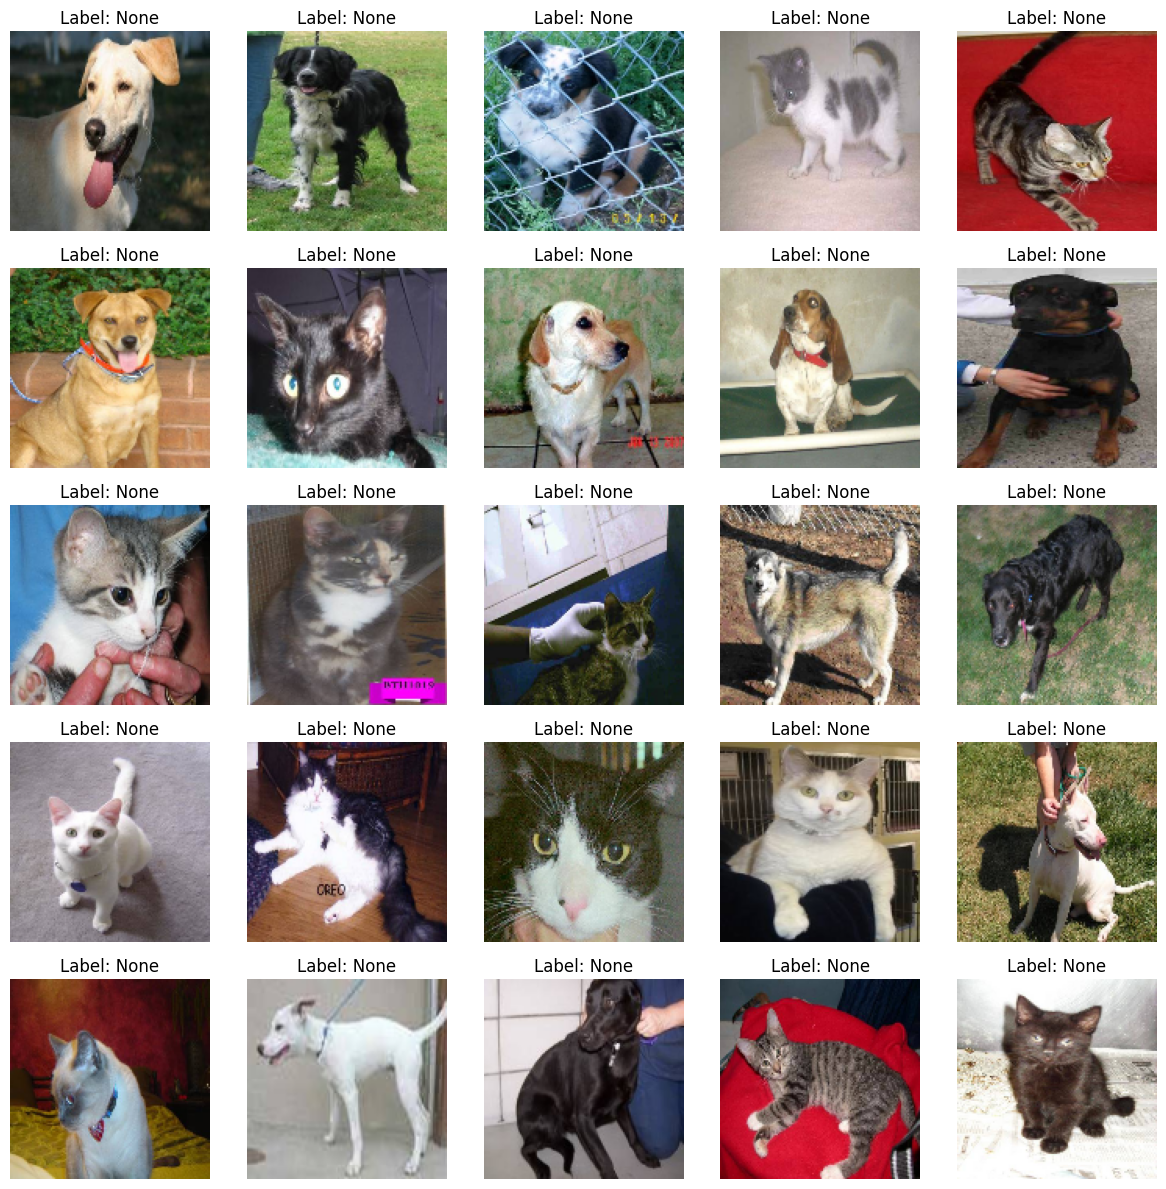

In [13]:
test = process_data(test_image_list, test_inner_folder, False)
show_images(test, True)

In [14]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array([i[1] for i in train])
print("X shape:", X.shape, "y shape:", y.shape)

X shape: (20000, 128, 128, 3) y shape: (20000, 2)


In [15]:
base = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    pooling='avg'
)
for layer in base.layers[:-10]:
    layer.trainable = False
for layer in base.layers[-10:]:
    layer.trainable = True


model = Sequential()
model.add(base)
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

I0000 00:00:1763737784.017685      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,770 (91.98 MB)

 Trainable params: 3,941,634 (15.04 MB)

 Non-trainable params: 20,171,136 (76.95 MB)

In [18]:
# === Save Model v2 architecture as model_v2.py ===

model_v2_code = """
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def get_model_v2(IMG_SIZE=128, NUM_CLASSES=2):
    base = ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        pooling='avg'
    )

    for layer in base.layers[:-10]:
        layer.trainable = False
    for layer in base.layers[-10:]:
        layer.trainable = True

    model = Sequential()
    model.add(base)
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(NUM_CLASSES, activation='softmax'))

    return model
"""

with open("/kaggle/working/models/model_v2.py", "w") as f:
    f.write(model_v2_code)

print("Saved → /kaggle/working/models/model_v2.py")


Saved → /kaggle/working/models/model_v2.py


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

datagen = ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = datagen.flow(X, y, batch_size=BATCH_SIZE, subset='training')
val_generator = datagen.flow(X, y, batch_size=BATCH_SIZE, subset='validation')


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

train_model = model.fit(
    train_generator,
    epochs=NO_EPOCHS,
    validation_data=val_generator,
    verbose=1,
    callbacks=[early_stop]
)
# === Save model v2 weights ===

# Save real TensorFlow weights
weight_path_h5 = "/kaggle/working/models/model_v2.weights.h5"
model.save_weights(weight_path_h5)

# Duplicate & rename to .pth for assignment
import shutil
shutil.copy(weight_path_h5, "/kaggle/working/models/model_v2.pth")

print("Saved:")
print(" - model_v2.weights.h5 (real TF weights)")
print(" - model_v2.pth (renamed copy for assignment)")



Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 70s 141ms/step - accuracy: 0.8691 - loss: 0.3218 - val_accuracy: 0.9095 - val_loss: 0.2124
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 65s 130ms/step - accuracy: 0.8907 - loss: 0.2486 - val_accuracy: 0.9107 - val_loss: 0.2103
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 65s 130ms/step - accuracy: 0.8994 - loss: 0.2297 - val_accuracy: 0.9185 - val_loss: 0.1964
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 65s 131ms/step - accuracy: 0.9108 - loss: 0.2073 - val_accuracy: 0.9183 - val_loss: 0.2012
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 65s 129ms/step - accuracy: 0.9228 - loss: 0.1820 - val_accuracy: 0.9218 - val_loss: 0.1907
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 65s 130ms/step - accuracy: 0.9250 - loss: 0.1788 - val_accuracy: 0.9258 - val_loss: 0.1775
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 65s 131ms/step - accuracy: 0.9237 - loss: 0.1854 - val_accuracy: 0.9290 - val_loss: 0.1754
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 65s 130ms/step - accuracy: 0.9274 - loss: 0

In [20]:
# === Compute evaluation metrics and save metrics_v2.json ===

import json
from sklearn.metrics import accuracy_score, f1_score

# evaluate on validation generator
val_pred = model.predict(X)
val_pred_classes = np.argmax(val_pred, axis=1)
y_true_classes = np.argmax(y, axis=1)

acc_v2 = accuracy_score(y_true_classes, val_pred_classes)
f1_v2 = f1_score(y_true_classes, val_pred_classes)

metrics_v2 = {
    "accuracy": float(acc_v2),
    "f1_score": float(f1_v2)
}

with open("/kaggle/working/results/metrics_v2.json", "w") as f:
    json.dump(metrics_v2, f, indent=4)

print("Saved → /kaggle/working/results/metrics_v2.json")


625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step
Saved → /kaggle/working/results/metrics_v2.json


In [23]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy'] if 'accuracy' in hist else hist.get('acc', [])
    val_acc = hist['val_accuracy'] if 'val_accuracy' in hist else hist.get('val_acc', [])
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()

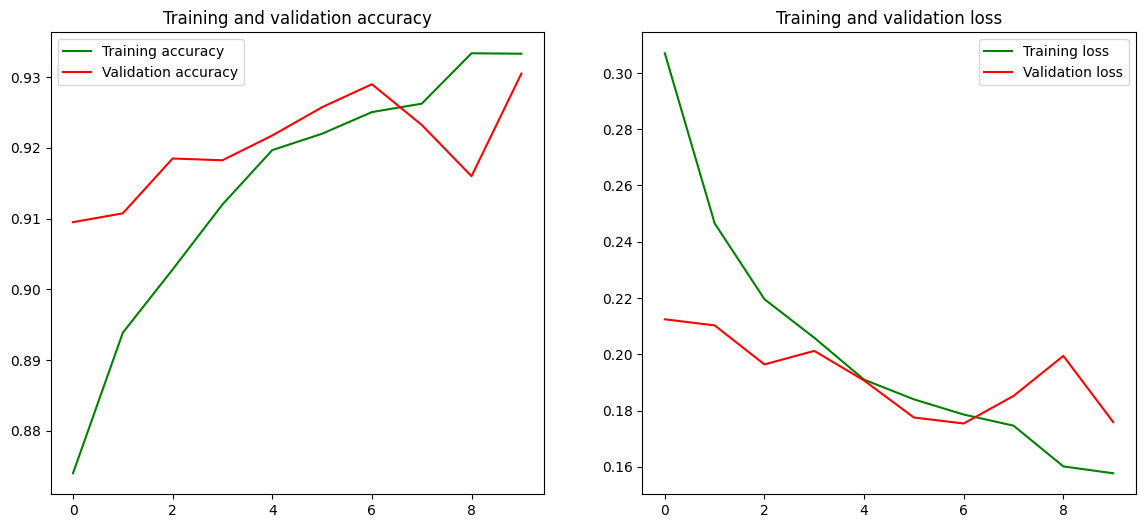

In [24]:
plot_accuracy_and_loss(train_model)

In [25]:
X_test = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
test_filenames = [str(i[1]) for i in test]


y_pred_proba = model.predict(X_test)
predicted_classes = np.argmax(y_pred_proba, axis=1)

test_ids = [int(os.path.splitext(f)[0]) for f in test_filenames]

submission = pd.DataFrame({
    'id': test_ids,
    'label': predicted_classes
})

submission.to_csv('submission.csv', index=False)

391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step


In [26]:
submission.head()

id  label
0   7448      1
1    363      1
2   7928      1
3   4563      0
4  10933      0

In [27]:
submission.shape

(12500, 2)

In [29]:
from IPython.display import FileLink
FileLink('/kaggle/working/models/model_v2.pth')


/kaggle/working/models/model_v2.pth